In [1]:
import sys
sys.path.insert(0, '../')

import fiftyone as fo
from fiftyone import ViewField as F

from models.custom import AHOY
from horizon.dataloaders import get_val_rgb_dataloader

dataset_name = "SAILING_DATASET_RGB_2023_10"
train_tag, val_tag = "TRAIN_v0", "VAL_v0"
imgsz = 1280

dataloader = get_val_rgb_dataloader(
        dataset=(fo.load_dataset(dataset_name)
                .match(F("ground_truth_pl.polylines.closed") == [False])
                .match_tags(val_tag)
                #.match(F("trip") == "Trip_306")
                #.take(5000, seed=51)
                ),
        imgsz=imgsz,
        batch_size=1,
        num_workers=0,
        shuffle=True,
    )

detector_weigths = "../yolos/yolov5n6_RGB_D2304-v1_9C.pt"
horizon_weights = "../runs/horizon/train/SAILING_DATASET_RGB_2023_10-1280/best.pt"
ahoy = AHOY(detector_weigths, horizon_weights, fp16=True)

🚀 SEA.AI custom version


YOLOv5 🚀 v7.0-334-g0d17d9ee Python-3.10.11 torch-2.1.0 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11004MiB)

Fusing layers... 
Model summary: 206 layers, 3102712 parameters, 0 gradients, 4.3 GFLOPs
Loaded weights from ../yolos/yolov5n6_RGB_D2304-v1_9C.pt
YOLOv5 🚀 v7.0-334-g0d17d9ee Python-3.10.11 torch-2.1.0 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11004MiB)

Fusing layers... 
Model summary: 108 layers, 3353720 parameters, 0 gradients, 4.6 GFLOPs
Loaded weights from ../runs/horizon/train/SAILING_DATASET_RGB_2023_10-1280/best.pt
YOLOv5 🚀 v7.0-334-g0d17d9ee Python-3.10.11 torch-2.1.0 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11004MiB)



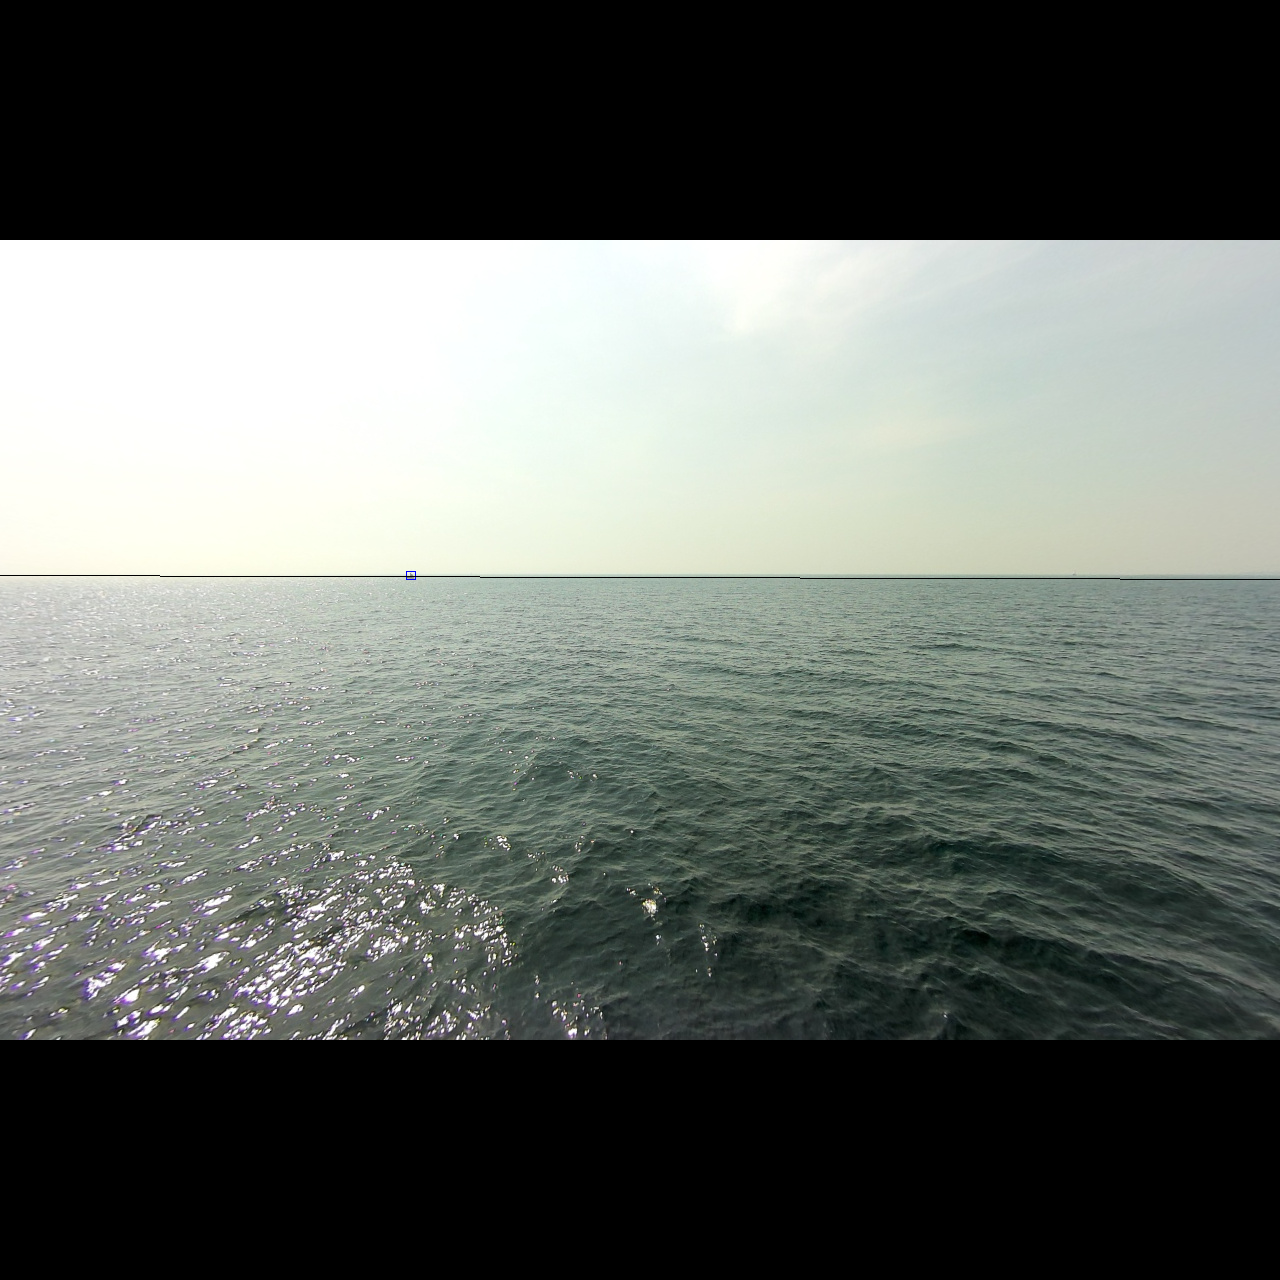

In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from PIL import Image

import torch

import plotly.express as px
import plotly.graph_objects as go

from utils.general import non_max_suppression
from utils.horizon import draw_horizon, draw_bboxes

for image, target in dataloader:
   break

def postprocess_x_pitch_theta(x_pitch, x_theta):
    # curve fitting
    def gaussian(x, A, mu, sigma):
        return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

    x_pitch = x_pitch.squeeze().cpu().numpy()
    x_theta = x_theta.squeeze().cpu().numpy()

    # Initial guess for the parameters (amplitude, mean, standard deviation)
    pitch0 = [x_pitch.max(), x_pitch.argmax() / x_pitch.shape[-1], 0.001]
    theta0 = [x_theta.max(), x_theta.argmax() / x_theta.shape[-1], 0.001]

    x_data = np.linspace(0, 1, x_pitch.shape[0], endpoint=False)
    params_pitch, cov_pitch = curve_fit(gaussian, x_data, x_pitch, p0=pitch0)
    params_theta, cov_theta = curve_fit(gaussian, x_data, x_theta, p0=theta0)

    return params_pitch[1], params_theta[1]

def postprocess_dets(
        dets,
        conf_thres=0.25,
        iou_thres=0.1,
        classes=None,
        agnostic_nms=True,
        max_det=100
):           
    dets = non_max_suppression(dets, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
    return dets[0].cpu().numpy()

ahoy.eval()
with torch.no_grad():
    x = image.to(ahoy.device)
    x = x.half() if ahoy.fp16 else x.float()
    dets, x_pitch, x_theta = ahoy(x)
    dets = postprocess_dets(dets)
    pitch, theta = postprocess_x_pitch_theta(x_pitch, x_theta)

I = (image[0].permute(1,2,0) * 255).numpy().astype(np.uint8)
diameter = 1
I = draw_bboxes(I, dets, color=(0,0,255), thickness=1)
# I = draw_horizon(I, pitch_theta=(target[0][0], target[0][1]), color=(0,255,0), diameter=diameter)
I = draw_horizon(I, pitch_theta=(pitch, theta), color=(0,0,0), diameter=diameter)
I = Image.fromarray(I)
I #.reduce(2) if I.width >= 1024 else I

In [4]:
from pathlib import Path
from export import export_engine
from models.yolo import Detect

inplace = False # default
dynamic = False # default

# Update model
ahoy.eval()
for k, m in ahoy.named_modules():
    if isinstance(m, Detect):
        m.inplace = inplace
        m.dynamic = dynamic
        m.export = True


ahoy.register_export_hooks()
# verify
x = image.to(ahoy.device)
out = ahoy(x)
print(x.dtype, [o[0].dtype for o in out])

export_engine(
    ahoy,
    im=image.to(ahoy.device),  #.half() if ahoy.fp16 else image.to(ahoy.device).float(),
    file=Path("ahoy.engine"),
    half=ahoy.fp16,
    #opset=12,
    dynamic=dynamic,
    simplify=False,
)


ONNX: starting export with onnx 1.13.1...


torch.float32 [torch.float32, torch.float32, torch.float32]


/home/kevinserrano/GitHub/yolov5/hybrids/../models/yolo.py:153: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if profile:
/home/kevinserrano/GitHub/yolov5/hybrids/../models/yolo.py:157: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if visualize:
/home/kevinserrano/GitHub/yolov5/hybrids/../models/yolo.py:157: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize 

TensorRT: input "images" with shape(1, 3, 1280, 1280) DataType.FLOAT
TensorRT: output "output0" with shape(1, 102000, 14) DataType.FLOAT
TensorRT: output "output1" with shape(1, 500) DataType.FLOAT
TensorRT: output "output2" with shape(1, 500) DataType.FLOAT
TensorRT: building FP16 engine as ahoy.engine


[03/26/2024-00:42:57] [TRT] [I] [MemUsageChange] Init CUDA: CPU +2, GPU +0, now: CPU 639, GPU 588 (MiB)
[03/26/2024-00:43:01] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU +895, GPU +172, now: CPU 1610, GPU 760 (MiB)
[03/26/2024-00:43:01] [TRT] [I] ----------------------------------------------------------------
[03/26/2024-00:43:01] [TRT] [I] Input filename:   ahoy.onnx
[03/26/2024-00:43:01] [TRT] [I] ONNX IR version:  0.0.7
[03/26/2024-00:43:01] [TRT] [I] Opset version:    12
[03/26/2024-00:43:01] [TRT] [I] Producer name:    pytorch
[03/26/2024-00:43:01] [TRT] [I] Producer version: 2.1.0
[03/26/2024-00:43:01] [TRT] [I] Domain:           
[03/26/2024-00:43:01] [TRT] [I] Model version:    0
[03/26/2024-00:43:01] [TRT] [I] Doc string:       
[03/26/2024-00:43:01] [TRT] [I] ----------------------------------------------------------------
[03/26/2024-00:43:01] [TRT] [W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not nat